# The particle filter

The model below is taken from the [paper](https://link.springer.com/content/pdf/10.1007/s11222-019-09884-y.pdf), Section 5.3 with simplifications.

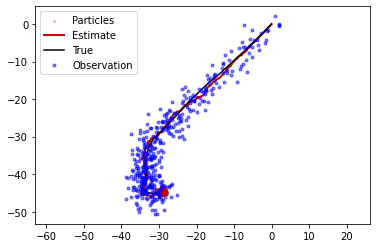

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters

kappa = 0.04
# A will be 4x4 dimensional matrix, the upper left block is identity of size 2x2 and the lower right block is 0.99 * identity of size 2x2, the upper right block is kappa * identity of size 2x2 and the lower left block is 0
A = np.array([[1, 0, kappa, 0], [0, 1, 0, kappa], [0, 0, 0.99, 0], [0, 0, 0, 0.99]])
Q = np.array([[kappa**3/3, 0, kappa**2/2, 0], [0, kappa**3/3, 0, kappa**2/2], [kappa**2/2, 0, kappa, 0], [0, kappa**2/2, 0, kappa]])

# Define the initial state
T_ssm = 400
x = np.zeros((4, T_ssm))
y = np.zeros((2, T_ssm))

x[:, 0] = np.array([0, 0, -10, -10])


H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
sig_y = 5
R = sig_y * np.eye(2)
y[:, 0] = H @ x[:, 0] + np.random.multivariate_normal(np.zeros(2), R)

for t in range(1, T_ssm):
    x[:, t] = A.dot(x[:, t-1]) + np.random.multivariate_normal(np.zeros(4), Q)
    y[:, t] = H.dot(x[:, t]) + np.random.multivariate_normal(np.zeros(2), R)

N = 1000
x_particles = np.zeros((4, N))
x_particles[:, :] = np.random.multivariate_normal(x[:, 0], 1 * np.eye(4), N).T
x_particles_pred = np.zeros((4, N))

x_est = np.zeros((4, T_ssm))

log_w = np.zeros(N)

x_particles = np.random.multivariate_normal(x[:, 0], 0.1 * np.eye(4), N).T

for t in range(1, T_ssm):
    # Prediction step
    x_particles_pred = A @ x_particles + np.random.multivariate_normal(np.zeros(4), Q, N).T

    # Update step
    for i in range(N):
        log_w[i] = log_w[i] - 0.5 * (y[:, t] - H @ x_particles_pred[:, i]).T @ np.linalg.inv(R) @ (y[:, t] - H @ x_particles_pred[:, i])

    W = np.exp(log_w - np.max(log_w))

    w = W / np.sum(W)
    # print(w)

    x_est[:, t] = np.sum(w * x_particles_pred, axis=1)

    x_particles = x_particles_pred[:, np.random.choice(N, N, p=w)]
    log_w = np.zeros(N)

    # print(t)
plt.scatter(x_particles[0, :], x_particles[1, :], color = [0.8, 0, 0], alpha=0.2, s=5)
plt.plot(x_est[0, :t], x_est[1, :t], color = [0.8, 0, 0], linewidth=2)
plt.plot(x[0, 0:t+1], x[1, 0:t+1], 'k')
plt.plot(y[0, 0:t], y[1, 0:t], 'b.', alpha = 0.5)
plt.axis('equal')
plt.legend(['Particles', 'Estimate', 'True', 'Observation'])
plt.show()
